# Machine Learning project
By Mattia Barbiere

In this project I was tasked to compare the performance of two models when applied the problem of classifying the given dataset. The models I am considering are K Nearest Neighbor and Logistic Regression. Each of these models can be implemented with various parameters which I will explore as we use Grid Search to find the optimal combination of parameters. My goal is to train and test the two models separately and then compare their performance so that I may crown which model is the best.

In [1010]:
%config InlineBackend.figure_formats = ['svg'] #To improve graph resolution
import sklearn
import pandas as pd
import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Before we try to fit the models we should first see what kind of data we are dealing with. This helps us to get a feel for the data so we can already start understanding whether our models are a good choice or not. As we will see the data provided is already very clean. There are no missing entries and there are no duplicates. This means that the data exploration will mainly be a visualization of the data for us to get a better understanding of what we are dealing with.

In [1011]:
df = pd.read_csv("mldata_0003151393.csv", index_col=0)
X = df[df.columns[1:]]
y = df['label']

We are given a dataset with 1200 example and 20 numeric features with 5 possible labels.

In [1012]:
print(df['label'].value_counts().sort_index(), "\n")
print("Shape of the dataset: ", df.shape)
df.head(5)

0    244
1    223
2    246
3    246
4    241
Name: label, dtype: int64 

Shape of the dataset:  (1200, 21)


,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,1,-2.887351,2.368955,-0.625925,-3.978334,-0.326955,4.055608,-0.235264,0.273827,-0.517484,...,1.510891,-0.111374,0.940897,-3.955810,-0.363500,0.199346,0.461904,-0.126972,1.626261,-0.182263
1,3,1.334865,-1.751757,-0.578244,-2.852914,-0.046243,-0.404612,4.838986,2.054794,0.641435,...,-1.172510,-0.015095,0.175453,-2.446950,-0.718050,0.596897,0.170454,-1.004904,2.982466,-3.522866
2,0,-1.073810,3.398483,-1.099216,1.529714,1.319205,4.183233,-4.627822,0.452511,3.557216,...,0.821012,6.678114,-0.540001,1.582700,0.466075,-2.284209,0.133034,0.216640,2.448328,2.277177
3,3,-1.459105,0.604342,-0.052011,0.196076,2.174851,-0.732217,-1.997095,2.443736,3.655130,...,0.491459,-0.112123,1.388338,-2.690753,0.997441,-0.957406,-1.423567,-0.276991,0.858894,-0.212745
4,2,0.508266,3.532480,-0.196915,-3.370030,0.177465,0.025390,2.840482,1.251280,-3.536680,...,0.758948,-5.192279,-0.341884,-2.078780,1.978526,1.532484,2.001019,-1.013421,-1.295467,-1.002012


As previously mentioned the data is already quite clean with no duplicate rows and no missing values.

In [1013]:
#Duplicate rows and missing values
print("Number of missing values: ", df.isna().stack().sum())
print("Number of duplicate rows: ", df[df.duplicated(keep=False)].shape[0])

Number of missing values:  0
Number of duplicate rows:  0


The best way to understand the distribution of the data is to make a histogram for every feature. This is where we could choose whether or not to transform the data. Luckily for me the distribution below are already very well behaved. They all follow a gaussian distribution with mean close to zero. Their standard deviations however do vary.

Notice that all the graphs are on the same scale so we can really compare them without worrying about distortions with the scales of the axis.

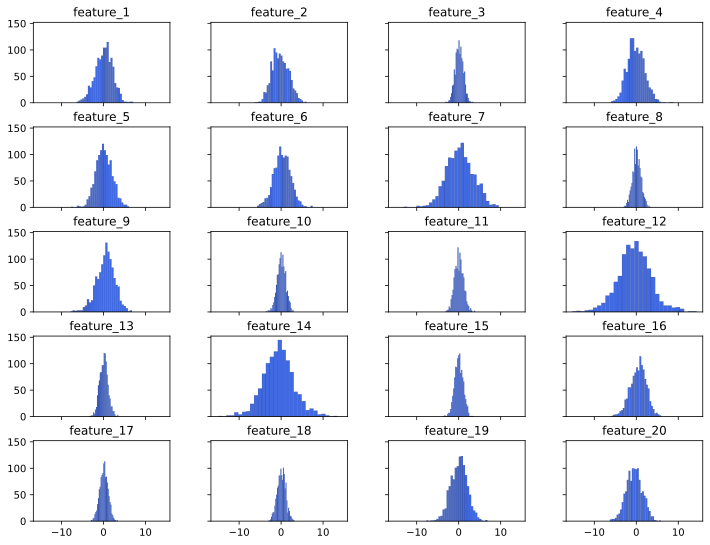

In [1085]:
#Histogram for every feature all in the same scale
X.hist(bins=30, 
       figsize=(12,9), 
        color="royalblue",
        ec="black", 
        lw=0.1, 
        grid=False, 
        sharex='col', 
        sharey='row')
plt.show()


The boxplot of the data tells a similar story, we see that the median is close to zero for every feature while the interquantile ranges do in fact vary.

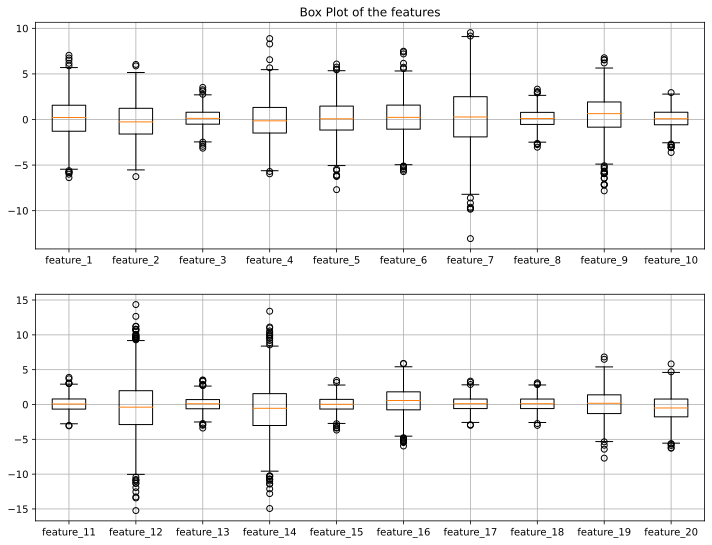

In [1083]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9))
ax1.boxplot(X[X.columns[:10]], labels=X.columns[:10])
ax1.grid()
ax2.boxplot(X[X.columns[10:]], labels=X.columns[10:])
ax2.grid()
ax1.set_title("Box Plot of the features")
plt.show()

We see that `feature_17` has a much smaller variance compared to `feature_1`. This may lead us to believe that scaling the data might be a good idea. In fact this is the approach I will take in the beginning, however Grid Search will later tell us that the models actually perform better if we do not scale the data.

Next we numerically calculate what the graph above illustrates.

In [1015]:
#Descriptive aspects of the data
X.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,1200.0,0.101575,2.078299,-6.378028,-1.287177,0.221206,1.564032,7.044498
feature_2,1200.0,-0.166710,1.981571,-6.266420,-1.594085,-0.263605,1.224438,6.042347
feature_3,1200.0,0.132981,0.967590,-3.145218,-0.512257,0.125932,0.793849,3.520966
feature_4,1200.0,-0.087112,2.053683,-5.960159,-1.482476,-0.149005,1.324697,8.877270
feature_5,1200.0,0.125522,1.938720,-7.697257,-1.158171,0.069604,1.465483,6.083652
feature_6,1200.0,0.253446,2.006632,-5.721129,-1.060267,0.230359,1.581070,7.492904
feature_7,1200.0,0.313112,3.200007,-13.068389,-1.906664,0.277519,2.503021,9.531424
feature_8,1200.0,0.107007,1.010086,-3.038071,-0.543744,0.112021,0.779632,3.329917
feature_9,1200.0,0.488320,2.187284,-7.828465,-0.844002,0.640040,1.920727,6.772510
feature_10,1200.0,0.093529,1.012772,-3.620827,-0.581886,0.086866,0.794594,2.951366


This descriptive table reinforces what was previously said. We see that the distributions do have mean close to 0 and standard deviation between 1 and 4. Secondly as 25% and 75% quantiles are symmetric with respect to the mean we can again conclude that the distribution are relatively symmetric with respect to the mean.

We next move to the correlation among features. This helps us understand if there are any obvious underlying patterns among the features. If two features are very correlated then this might be an indication that they are somewhat dependent on each other.

Total average correlation:  0.05599543199968648
Average correlation for each feature: 
 feature_1     0.098121
feature_2    -0.004305
feature_3     0.041617
feature_4     0.035590
feature_5     0.072204
feature_6     0.111855
feature_7    -0.063248
feature_8     0.046115
feature_9     0.012310
feature_10    0.051752
feature_11    0.045150
feature_12    0.135671
feature_13    0.059532
feature_14    0.138615
feature_15    0.058017
feature_16    0.025011
feature_17    0.043796
feature_18    0.050822
feature_19    0.075835
feature_20    0.085448
dtype: float64


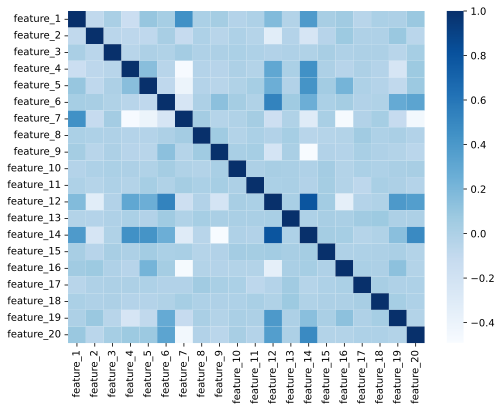

In [1016]:
#Correlation amoung features
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), cmap='Blues')
print("Total average correlation: ", X.corr().stack().mean())
print("Average correlation for each feature: \n", X.corr().mean())
plt.show()

Unfortuntely it seems that there is very little correlation among my features. There are some correlations in some places however we should take these with a grain of salt as these could be entirely due to chance and not because of any underlying structure. Nevertheless, we can still plot some of these correlations on a scatter matrix.

By looking at the heatmap above we can visually see which features tend to be more correlated (positively or negatively). From this I chose features 12,14 and 20 to be represented in the next scatter matrix.

As with every scatter matrix bare in mind that the scale of the histograms is different from the scale of the scatter plots.

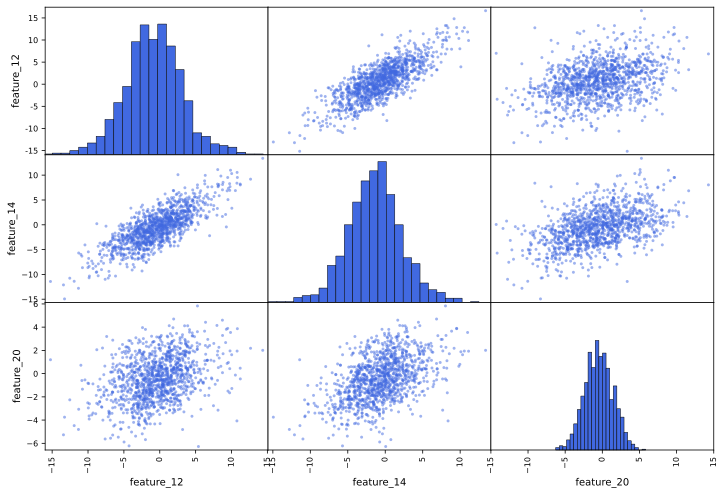

In [1017]:
from pandas.plotting import scatter_matrix

#Displaying the scatter matrix with the chosen features
features = ["feature_12", "feature_14", "feature_20"]

s = scatter_matrix(df[features], figsize=(12, 8), c="royalblue", 
                hist_kwds={'bins': 25, 'color': "royalblue", 'ec': 'black', 'lw': 0.5})

#Changing scale of all the histograms so they are easier to compare
for i in range(3):
    s[i][i].set_xlim([-15,15])
    s[i][i].set_ylim([0,175])
plt.show()


It is quite surprising the correlation between feature 12 and 14. Coincidently the features I chose are also the features with the highest standard deviation. The standard deviation of feature 12 and 14 only differ by about 0.3. This could explain why they are slightly correlated with each other since their histograms are all quite spread out compared to the other features. 

## Defining and training the models

We can now start working with the models. Before training we should check that we have sufficient examples for each label so that our model remain as unbiased as possible.

In [1018]:
# Percentage of examples for each label
round((y.value_counts().sort_index()/df.shape[0]) * 100, 2)

0    20.33
1    18.58
2    20.50
3    20.50
4    20.08
Name: label, dtype: float64

Overall the examples for each label are very balanced. This a good sign as we have sufficient examples from each class to train our classifiers. This also removes a layer of complexity in the training of our model.

As always we start off by splitting the data into train and test sets in order to test the models on new data later on. As our initial dataset had a balanced proportion of labels and we want to check that this remains true in the train and test datasets in order to avoid any bias. Theoretically our dataset should be large enough that a random sample directly achieves a balanced label dataset however with `train_test_split(stratify=y)` we are certain that this indeed happens as we can see below.

In [1019]:
from sklearn.model_selection import train_test_split

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Label proportion in the train and test set
print("Label proportion for y_train: ")
print(round((y_train.value_counts().sort_index()/y_train.shape[0]) * 100, 2), "\n")
print("Label proportion for y_test: ")
print(round((y_test.value_counts().sort_index()/y_test.shape[0]) * 100, 2))

Label proportion for y_train: 
0    20.31
1    18.54
2    20.52
3    20.52
4    20.10
Name: label, dtype: float64 

Label proportion for y_test: 
0    20.42
1    18.75
2    20.42
3    20.42
4    20.00
Name: label, dtype: float64


To define the models we start off with a pipeline. This is a very simple pipeline as there is no need imputing or transformation of the data. Notice that we add `('scaler', StandardScaler())` to the pipeline. Initially I thought this would help the models perform better however Grid Search proved me wrong.

In [1020]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Making the one pipeline for each model
#-------K Nearest Neighbor-------
pipe_knn = Pipeline([
        ('scaler', StandardScaler()),
        ('KNN_model', KNeighborsClassifier())
    ])

#-------Logistic Regression-------
pipe_logi = Pipeline([
        ('scaler', StandardScaler()),
        ('logi_model', LogisticRegression(random_state=0))
    ])

#Fitting both pipelines
pipe_logi.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)

print(pipe_logi,"\n", pipe_knn)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logi_model', LogisticRegression(random_state=0))]) 
 Pipeline(steps=[('scaler', StandardScaler()),
                ('KNN_model', KNeighborsClassifier())])


## Performance Measures

The main objective of this project was comparing K Nearest Neighbor to Logistic Regression. In order to do so we need to evaluate the performance of the two models in such a way we can compare the outcomes. As I will have to do this a few times I created a function that outputs all the performance measures we need.
As performance measures I chose:
* `cross_val_score().mean()`: This executes k fold cross validation and returns the average accuracy. This may be the best performance measure as it will give us a score while eliminating any bias we have in our train-test split.

* `pipeline.score(X_test, y_test)`: This simply evaluates the model with the test data and comparing it to the true labels to get an accuracy of the model.

* `Precision, Recall and F1 scores`: These are standard measures of performance depending on the number of true positive, true negatives, false postives and false negatives. The only subtelty is that we are in a multiclass setting so we have to choose how to calculate them over all the labels. I chose to take `average='macro'` which calculates the scores for each label individually and then takes the average. However with `average='micro'`(which counts the global TP,TN,FP and FN) the final score changed by at most 1%. 

* `Confusion Matrix`: With the confusion matrix will be able to understand where are models are misclassifying the labels. I plotted this using a heatmap to help with the visualization.

In [1102]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#Number of folds for cross validation
kfold=5

#A function which returns all the permormance measures we want
def permormance(pipeline: sklearn.pipeline.Pipeline, title: str = "", when: str = "", show: bool = True):
      """
      Given as input a pipeline (with a model) and a title it returns some performance measures of that pipeline
      """
      #Calculating all the scores
      cv_score = round(cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='accuracy').mean() * 100,2)
      accuracy = round(pipeline.score(X_test, y_test) * 100,2)
      precision = round(precision_score(y_test, pipeline.predict(X_test), average='macro') * 100,2)
      recall = round(recall_score(y_test, pipeline.predict(X_test), average='macro') * 100,2)
      f1 = round(f1_score(y_test, pipeline.predict(X_test), average='macro') * 100,2)

      #We only print if show is True
      if show:
            #Changing text based on the input "when"
            if when == "before":
                  print(title + " before Grid Search:")
            elif when == "after":
                  print(title + " after Grid Search:")
            
            #Displaying the mean CV score
            print(" Mean CV score: ", f"{cv_score}%")
            
            #Displaying the accuracy
            print(" Accuracy: ", f"{accuracy}%")

            #Displaying the average (Macro) precision
            print(" Average macro precision: ", f"{precision}%")
            
            #Displaying the average (Macro) recall
            print(" Average macro recall: ", f"{recall}%")
            
            #Displaying the average (Macro) F1 score
            print(" Average macro F1 score: ", f"{f1}%")
            
            #Plotting the heatmap to illustrate the confusion matrix
            plt.figure(figsize = (9,4), dpi=100)
            sns.heatmap(confusion_matrix(y_test, pipeline.predict(X_test)),
                        cmap = 'Blues',
                        annot = True)
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            plt.title("Confusion matrix:")
            plt.show()
      else:
            #If we do not want to print the values we return a dict with all the measures
            perform_dict = {
                  'Mean CV score': f"{cv_score}%",
                  'Accuracy': f"{accuracy}%",
                  'Average macro precision': f"{precision}%",
                  'Average macro recall': f"{recall}%",
                  'Average macro F1 score': f"{f1}%"}
            return perform_dict


K Nearest Neighbor before Grid Search:
 Mean CV score:  69.79%
 Accuracy:  76.67%
 Average macro precision:  77.93%
 Average macro recall:  76.72%
 Average macro F1 score:  76.57%


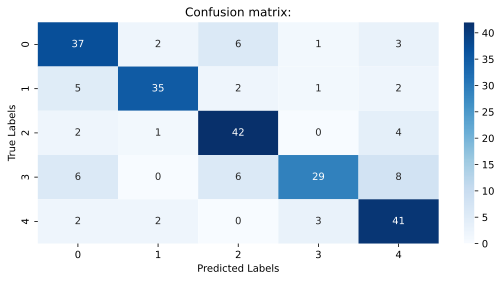

Logistic Regression before Grid Search:
 Mean CV score:  47.6%
 Accuracy:  44.58%
 Average macro precision:  42.9%
 Average macro recall:  44.02%
 Average macro F1 score:  41.31%


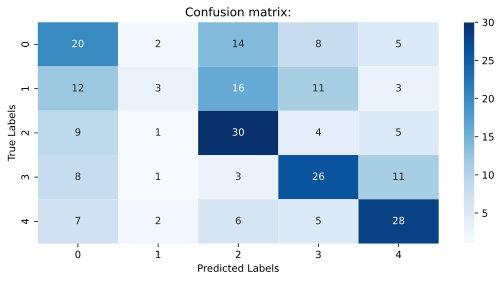

In [1103]:
#Performance measures before Grid Search
#-------K Nearest Neighbor-------
permormance(pipe_knn, "K Nearest Neighbor", "before")
#Save this for later
knn_perf_beforeGS = permormance(pipe_knn, show=False)

#-------Logistic Regression-------
permormance(pipe_logi, "Logistic Regression", "before")
#Save this for later
logi_perf_beforeGS = permormance(pipe_logi, show=False)

K Nearest Neighbor comes out on top with a much better confusion matrix. In fact Logistic Regression seems to have a very hard time classifying example with label 1. Unfortunatly this problem will presists even after Grid Search.

## Grid Search for the best hyperparameters

### K Nearest Neighbor

We would like to tune our models in such a way that we get the best performance out of them. To find the best hyperparameters we will run Grid Search on the two models and see which combination of hyperparameters is the best.

We can start with the Grid Search for K Nearest Neighbor. These are the parameters I am going to look through:
* __Scaler__ : I chose the most widely used scalers: `StandardScaler()` and `MinMaxScaler()`. I also gave it the option of not choosing any scaler.

* __Algorithm__ : The sklearn library allows `KNeighborsClassifier()` to have different algorithms, I want to find the best one for our data as the algorithm can have a very large effect on the resulting performance of a model. 

* __Leaf Size__ : This is the size of the leaf nodes if you use the `'ball_tree'` or `'kd_tree'` algorithms. This is like a stopping criterion for the trees the two algorithms construct.

* __Number of neighbors__ : This tells us how many neighbors to take into consideration when classifying a data point. This is a very important parameter as it severely affect the classifying of data points and can be vital for better accuracy.

* __p__ : This is the parameter that defines the distance measure (Minkowski metric), in my case I chose 1 (L1 norm) or 2 (L2 norm). This helps to define the notion of distance which for us is very simple as our data is numeric.

* __Weights__ : When taking the majority vote to decide the label of a specific data point, this parameter tells us if we should consider every vote as equal or if we should take a weighted sum of the votes with weights that are inversely proportional to the distance. Again this parameter as a large effect on how our model labels data points.

In [1023]:
from sklearn.model_selection import GridSearchCV

#Grid search for K Nearest Neighbors
g_param_knn = {'scaler': [StandardScaler(), MinMaxScaler(), None],
                'KNN_model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                'KNN_model__leaf_size': [1, 5],
                'KNN_model__n_neighbors': [7, 8, 9, 10],
                'KNN_model__p': [1, 2],
                'KNN_model__weights': ['uniform', 'distance']}
g_knn = GridSearchCV(pipe_knn, g_param_knn, cv=kfold, scoring='accuracy', n_jobs=-1)
g_knn.fit(X_train, y_train)

#Results of Grid Search
print("Best score from Grid Search for KNN: ", f"{round(g_knn.best_score_ * 100, 2)}%")
print("Best parameters given by Grid Search for K Nearest Neighbor: ")
g_knn.best_params_


Best score from Grid Search for KNN:  69.79%
Best parameters given by Grid Search for K Nearest Neighbor: 


{'KNN_model__algorithm': 'ball_tree',
 'KNN_model__leaf_size': 1,
 'KNN_model__n_neighbors': 9,
 'KNN_model__p': 2,
 'KNN_model__weights': 'distance',
 'scaler': None}

We see that in fact the scaler was not needed and K Nearest Neighbor actually works better without it. Actually the performance of K Nearest Neighbor goes up by almost 10% which is a great improvement from the first K Nearest Neighbor model we tried. We will do a more detailed comparison in the Conclusions section.

K Nearest Neighbor after Grid Search:
 Mean CV score:  69.79%
 Accuracy:  76.67%
 Average macro precision:  77.93%
 Average macro recall:  76.72%
 Average macro F1 score:  76.57%


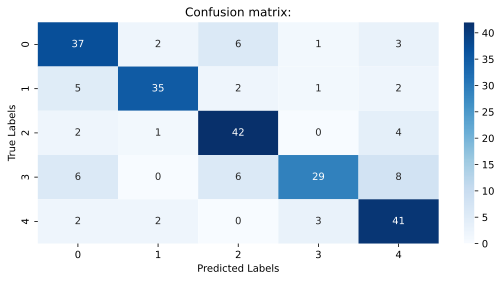

In [1024]:
#Setting pipeline to the best estimator given by grid search (as rifit = True by default)
pipe_knn = g_knn.best_estimator_
permormance(pipe_knn, "K Nearest Neighbor", "after")

#Save this for later
knn_perf_afterGS = permormance(pipe_knn, show=False)

The confusion matrix presented above seems to be quite good. The model does have some problems in some areas however the large majority of the predictions are correct. This is already a good model and, as we will see, this is much better than the confusion matrix we will get from the best Logistic Regression model.

### Logistic Regression

When it comes to Logistic Regression I found that there were many more hyperparameters to tune and this led to a very computationally intensive Grid Search. For this reason I had to reduce my options of possible parameter values.
I ended up with the following parameters options:

* __Scaler__ : Same as before; I choose which scaler (if any) is best for our model.

* __Penalty__ : This chooses whether we should use regularization or not. If we choose to use it we can only use l2 norm regularization as our solvers do not support l1 regularization. This is important to prevent overfitting our data to the model.

* __C__ : This is the inverse of the regularization coefficient. It is important to tune this parameter however it only has meaning if we use regularization and for this reason I make two separate dictionaries for the possible parameter values(one with regularization and one without). The `np.logspace()` function helps to get different values with varying powers of 10.

* __Multi_class__ : As we are performing multiclass classification we need to specify this in the model parameters for the logistic regression. Our options are `multinomial` and `ovr`. The former uses the multinomial distribution as a loss function to train the model. The `ovr` on the other hand implements the One vs Rest idea in which the problem is subdivided into 5 binary classification problems. These two approaches are quite different and they may impact a lot the performance of the model.

* __Solver__ : There various solvers we could use for our logistic regression. To naorrow our search I will restrict our options only to solvers that can support multinomial loss (all solver can implement `ovr`).


In [1025]:
#Grid search for Logistic Regression
g_param_logi = [{'scaler': [StandardScaler(), MinMaxScaler(), None],
                'logi_model__penalty' : ['l2'],
                'logi_model__C' : np.logspace(-5, 5, 7),
                'logi_model__multi_class': ['multinomial', 'ovr'],
                'logi_model__solver': ['newton-cg', 'lbfgs', 'saga']
                },
                {'scaler': [StandardScaler(), MinMaxScaler(), None],
                'logi_model__penalty' : [None],
                'logi_model__multi_class': ['multinomial', 'ovr'],
                'logi_model__solver': ['newton-cg', 'lbfgs', 'saga']
                }]

g_logi = GridSearchCV(pipe_logi, g_param_logi, cv=kfold, scoring='accuracy', n_jobs=-1)
g_logi.fit(X_train, y_train)

#Results of Grid Search
print("Best score from Grid Search Logistic Regression: ", f"{round(g_logi.best_score_ * 100, 2)}%")
print("Best parameters given by Grid Search for Logistic Regression: ")
g_logi.best_params_

Best score from Grid Search Logistic Regression:  47.6%
Best parameters given by Grid Search for Logistic Regression: 


{'logi_model__C': 0.021544346900318846,
 'logi_model__multi_class': 'ovr',
 'logi_model__penalty': 'l2',
 'logi_model__solver': 'newton-cg',
 'scaler': None}

Again notice that with no scaler the model works better!

Logistic Regression after Grid Search:
 Mean CV score:  47.6%
 Accuracy:  44.58%
 Average macro precision:  42.9%
 Average macro recall:  44.02%
 Average macro F1 score:  41.31%


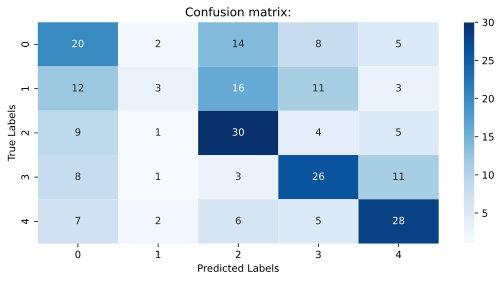

In [1026]:
#Setting pipeline to the best estimator given by grid search (as rifit = True by default)
pipe_logi = g_logi.best_estimator_
permormance(pipe_logi, "Logistic Regression", "after")

#Save this for later
logi_perf_afterGS = permormance(pipe_logi, show=False)


## Conclusions

Let's now summaries what we have done. We started of with the two models without any hyperparameter tunning. The performances were as follows:

In [1027]:
print("K Nearest Neighbor before Grid Search: ")
pprint.pprint(knn_perf_beforeGS)
print("\nLogistic Regression before Grid Search: ")
pprint.pprint(logi_perf_beforeGS)

K Nearest Neighbor before Grid Search: 
{'Accuracy': '65.83%',
 'Average macro F1 score': '65.88%',
 'Average macro precision': '66.96%',
 'Average macro recall': '66.0%',
 'Mean CV score': '59.27%'}

Logistic Regression before Grid Search: 
{'Accuracy': '44.58%',
 'Average macro F1 score': '42.46%',
 'Average macro precision': '43.71%',
 'Average macro recall': '44.11%',
 'Mean CV score': '46.04%'}


We see that for both models the performance measures seem to be pretty similar. K Nearest Neighor's measures are all 65% with the only exception being the mean cross validation score. There could be a specific fold in which the model behaves badly on the test set. Logistic Regression on the other hand has it's performance measures around 42-45 with it's mean cross validation score actually being the higher than the accuracy. Obviously we see that K Nearest Neighbor performes better in every regard. Both models however aren't performing the best right off the bat but we still have to use Grid Search which will hopefully improve the performances.

In [1028]:
print("K Nearest Neighbor after Grid Search: ")
pprint.pprint(knn_perf_afterGS)
print("\nLogistic Regression after Grid Search: ")
pprint.pprint(logi_perf_afterGS)

K Nearest Neighbor after Grid Search: 
{'Accuracy': '76.67%',
 'Average macro F1 score': '76.57%',
 'Average macro precision': '77.93%',
 'Average macro recall': '76.72%',
 'Mean CV score': '69.79%'}

Logistic Regression after Grid Search: 
{'Accuracy': '44.58%',
 'Average macro F1 score': '41.31%',
 'Average macro precision': '42.9%',
 'Average macro recall': '44.02%',
 'Mean CV score': '47.6%'}


When it comes to K Nearest Neighbor the improvement from Grid Search is almost 10% in all peformance measures. This is quite a substantial increase. Logistic Regression on the other hand doesn't gain much from Grid Search. We know that Grid Search uses the CV mean score as a criterion for ranking the performances of models and in the Logistic Regression case it does slightly increases but some measures actually decrease. I tried to vary the scoring criteria of Grid Search with little luck. So also in this case K Nearest Neighbor is the best model for our dataset. We can finally conclude that K Nearest Neighbor is the superior model!
Below you can find all the parameters of the best K Nearest Neighbor model I found.

In [1029]:
pipe_knn.get_params()

{'memory': None,
 'steps': [('scaler', None),
  ('KNN_model',
   KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=9,
                        weights='distance'))],
 'verbose': False,
 'scaler': None,
 'KNN_model': KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=9,
                      weights='distance'),
 'KNN_model__algorithm': 'ball_tree',
 'KNN_model__leaf_size': 1,
 'KNN_model__metric': 'minkowski',
 'KNN_model__metric_params': None,
 'KNN_model__n_jobs': None,
 'KNN_model__n_neighbors': 9,
 'KNN_model__p': 2,
 'KNN_model__weights': 'distance'}

## Appendix: Prediction file

In [1030]:
#Importing the final test dataset
df_final_test = pd.read_csv("mldata_0003151393.TEST_FEATURES.csv", index_col=0)

#Writing the predictions to the file
with open('test_predictions.txt', 'w') as f:
    for y in pipe_knn.predict(df_final_test):
        f.write(f"{y}\n")
